In [1]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()
md = Markdown("""
# Idea Summary - VIX based QQQ strengthen

**How I get my idea**

This strategy serves as a practice of a simple idea: \n
For QQQ, if VIX>a, buy in the close, if VIX<b, sell in the close.
Then for a period of 10 years what's the performance \n
Data used: Yahoo finance
""")
console.print(md)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                     Idea Summary - VIX based QQQ strengthen                                     ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

How I get my idea                                                                                                  

This strategy serves as a practice of a simple idea:                                                               

For QQQ, if VIX>a, buy in the close, if VIX<b, sell in the close. Then for a period of 10 years what's the         
performance                                                                                                        

Data used: Yahoo finance

Fetching data from 2016-01-08 to 2026-01-05...

=== Performance Report (10 Years) ===
Strategy Thresholds: Buy VIX>20, Sell VIX<15
Strategy CAGR: 20.84%
Benchmark (SPY) CAGR: 15.45%
Strategy Sharpe Ratio: 1.06
Benchmark (SPY) Sharpe Ratio: 0.89
Strategy Max Drawdown: -34.41%
Benchmark (SPY) Max Drawdown: -33.72%


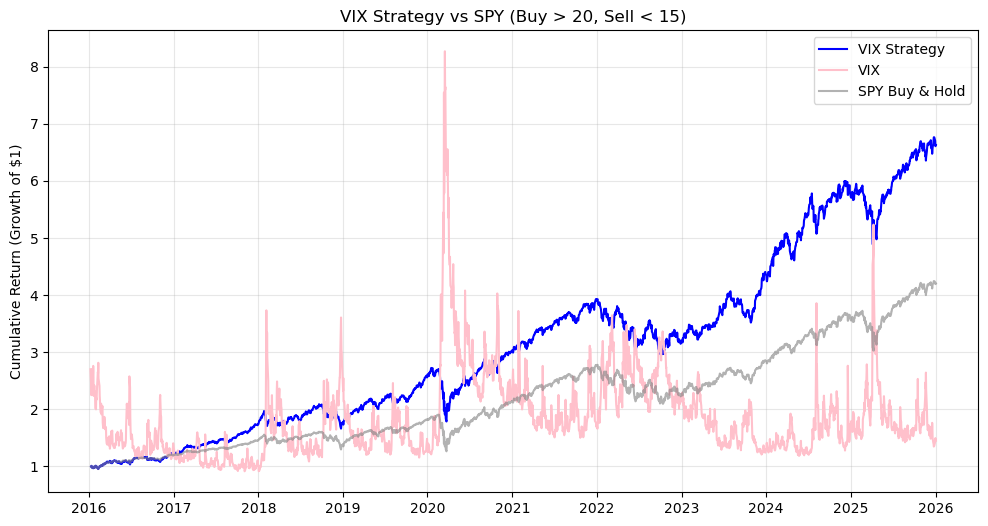

In [4]:
#Parameters area
A_BUY_THRESHOLD = 20  # "a": Buy when VIX > 25 (Fear)
B_SELL_THRESHOLD = 15 # "b": Sell when VIX < 15 (Greed)
long_position = 1
short_position = 1.9
normal_pos = 1

START_DATE = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d') # Last 10 years
END_DATE = datetime.now().strftime('%Y-%m-%d')

tickers = ['SPY', '^VIX']


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ==========================================
# 1. PARAMETERS & DATA FETCHING
# ==========================================
# Define strategy parameters


print(f"Fetching data from {START_DATE} to {END_DATE}...")

# Download data for SPY (ETF) and ^VIX (Volatility Index)

data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)['Close']

# Clean data and rename columns for easier access
df = data.copy()
df.columns = ['SPY', 'VIX']
df = df.dropna()

# ==========================================
# 2. STRATEGY LOGIC
# ==========================================
# Calculate daily returns for SPY (used for performance calculation)
df['SPY_Ret'] = df['SPY'].pct_change()

# Initialize 'Position' column: 1 = Long, 0 = Cash
# We use a loop here because the state depends on the previous day's holding status
df['Position'] = 0

# Convert columns to numpy arrays for faster iteration (optimizing speed)
vix_values = df['VIX'].values
positions = np.zeros(len(df))


for i in range(len(df)):
    current_pos = normal_pos 
    # "If VIX > a, buy in the close"
    if vix_values[i] > A_BUY_THRESHOLD:
        current_pos = long_position
    
    # "If VIX < b, sell in the close"
    elif vix_values[i] < B_SELL_THRESHOLD:
        current_pos = short_position
        
    # Else: Hold previous position (implied by not changing current_pos)
    positions[i] = current_pos

df['Position'] = positions

# ==========================================
# 3. BACKTEST PERFORMANCE
# ==========================================
# Shift position by 1 day to avoid look-ahead bias.
# Logic: We see VIX at Close(t), make decision, and buy at Close(t). 
# Our exposure begins for the return from Close(t) to Close(t+1).
df['Strategy_Ret'] = df['Position'].shift(1) * df['SPY_Ret']

# Cumulative Returns
df['SPY_Cum_Ret'] = (1 + df['SPY_Ret']).cumprod()
df['Strategy_Cum_Ret'] = (1 + df['Strategy_Ret']).cumprod()

# ==========================================
# 4. METRICS CALCULATION
# ==========================================
# Annualized Return (CAGR)
total_days = (df.index[-1] - df.index[0]).days
cagr_spy = (df['SPY_Cum_Ret'].iloc[-1])**(365/total_days) - 1
cagr_strat = (df['Strategy_Cum_Ret'].iloc[-1])**(365/total_days) - 1

# Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
sharpe_spy = (df['SPY_Ret'].mean() / df['SPY_Ret'].std()) * np.sqrt(252)
sharpe_strat = (df['Strategy_Ret'].mean() / df['Strategy_Ret'].std()) * np.sqrt(252)

# Max Drawdown
rolling_max_strat = df['Strategy_Cum_Ret'].cummax()
daily_drawdown_strat = df['Strategy_Cum_Ret'] / rolling_max_strat - 1.0
max_drawdown_strat = daily_drawdown_strat.min()

# Max Drawdown_SPY
rolling_max_spy = df['SPY_Cum_Ret'].cummax()
daily_drawdown_spy = df['SPY_Cum_Ret'] / rolling_max_spy - 1.0
max_drawdown_spy = daily_drawdown_spy.min()

print(f"\n=== Performance Report (10 Years) ===")
print(f"Strategy Thresholds: Buy VIX>{A_BUY_THRESHOLD}, Sell VIX<{B_SELL_THRESHOLD}")
print(f"Strategy CAGR: {cagr_strat:.2%}")
print(f"Benchmark (SPY) CAGR: {cagr_spy:.2%}")
print(f"Strategy Sharpe Ratio: {sharpe_strat:.2f}")
print(f"Benchmark (SPY) Sharpe Ratio: {sharpe_spy:.2f}")
print(f"Strategy Max Drawdown: {max_drawdown_strat:.2%}")
print(f"Benchmark (SPY) Max Drawdown: {max_drawdown_spy:.2%}")

# ==========================================
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Strategy_Cum_Ret'], label='VIX Strategy', color='blue')
plt.plot(df.index, df['VIX']/10, label='VIX', color='pink')
plt.plot(df.index, df['SPY_Cum_Ret'], label='SPY Buy & Hold', color='gray', alpha=0.6)
plt.title(f'VIX Strategy vs SPY (Buy > {A_BUY_THRESHOLD}, Sell < {B_SELL_THRESHOLD})')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()